# Testing different periodograms

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import P4J

In [3]:
#!pip install alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

In [4]:
# for the moment use the g band
def doperiod(LCdet, method):

    objperiod = {}
    freq = {}
    per = {}
    for fid in LCdet.fid.unique():
        maskdet = LCdet.fid == fid
        
        my_per = P4J.periodogram(method=method) # 'PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU'
        my_per.set_data(np.array(LCdet[maskdet].mjd), np.array(LCdet[maskdet].magpsf_corr),
                        np.array(LCdet[maskdet].sigmapsf_corr))
        my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-5)
        my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=1)#10)              
        freq[fid], per[fid] = my_per.get_periodogram()
        fbest, pbest = my_per.get_best_frequencies()
        objperiod[fid] = 1. / fbest
        print(fid, objperiod[fid])

    period = objperiod[1]
    
    return period, freq, per

In [5]:
def plotLC(oid, LCdet, LCnondet, dofold, period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for idx, fid in enumerate(LCdet.fid.unique()):
        maskdet = LCdet.fid == fid
        masknondet = (LCnondet.fid == fid) & (LCnondet.diffmaglim > -900)
        
        if dofold:
            phase = np.mod(LCdet[maskdet].mjd, period) / period
            for nphase in [0, 1]:
                ax.errorbar(phase + nphase, LCdet[maskdet].magpsf_corr, 
                        yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid], lw = 0)
        else:
            ax.errorbar(LCdet[maskdet].mjd, LCdet[maskdet].magpsf_corr, 
                    yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            ax.scatter(LCnondet[masknondet].index, LCnondet[masknondet].diffmaglim, c = colors[fid], alpha = 0.5,
                    marker = 'v', label = "lim.mag. %s" % labels[fid])
    if dofold:
        ax.set_title("%s (period: %.3f days" % (oid, period))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold:
        fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
        for idx, fid in enumerate(LCdet.fid.unique()):
            ax[idx].plot(freq[fid], per[fid])
            ax[idx].set_title("Periodogram %s" % labels[fid])
            ax[idx].set_xlabel("frequency [1/days]")

In [6]:
def getLCdata(oid, doplot=False, dofold=False):

    # query detections
    LCdet = client.get_detections(oid, format='pandas')
    LCdet.sort_values(by=["mjd"], inplace=True)
        
    # query non detections
    LCnondet = client.get_non_detections(oid, format='pandas')
    LCnondet.sort_index(inplace=True) # index is mjd

    if dofold:
        # get period
        period, freq, per = doperiod(LCdet, 'PDM1')
    else:
        period = None; freq = None; per = None  
    
    if doplot:
        plotLC(oid, LCdet, LCnondet, dofold, period=period, freq=freq, per=per)
        
    # return data
    return LCdet, LCnondet

ZTF18abuamei


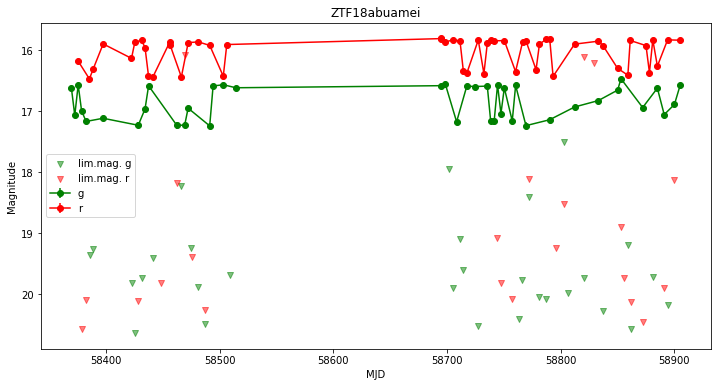

In [7]:
seloid = "ZTF18abuamei" # ZTF18abuamei is a difficult eclipsing binary
print(seloid)
LCdet, LCnondet = getLCdata(seloid, doplot = True, dofold = False);

PDM1
1 [0.26530758]
2 [0.26530758]
LKSL
1 [0.30600598]
2 [0.26530617]
MHAOV
1 [0.22061272]
2 [0.22061515]
QMICS
1 [0.22060739]
2 [0.26530758]
QMIEU
1 [0.22060786]
2 [0.22061226]


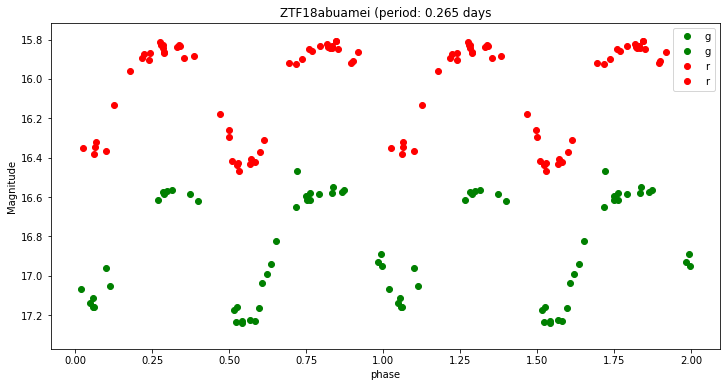

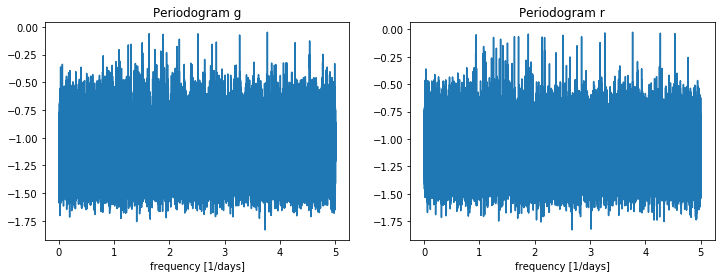

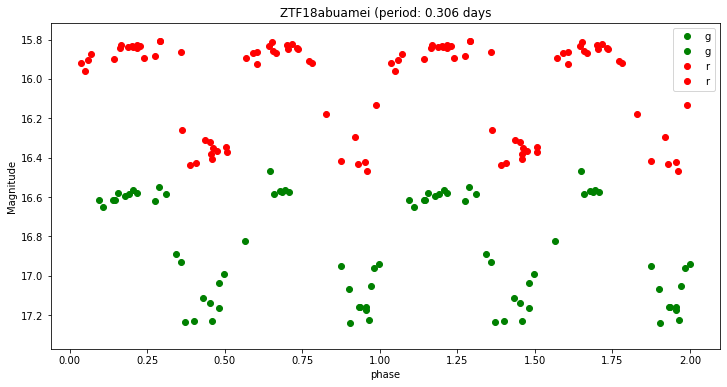

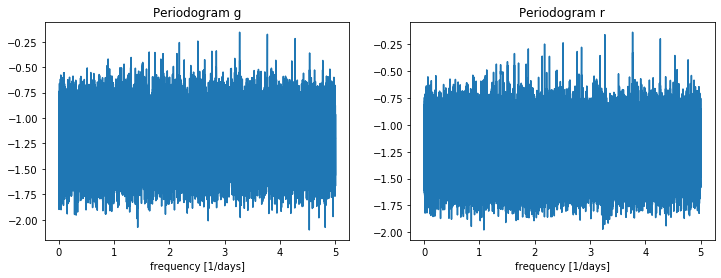

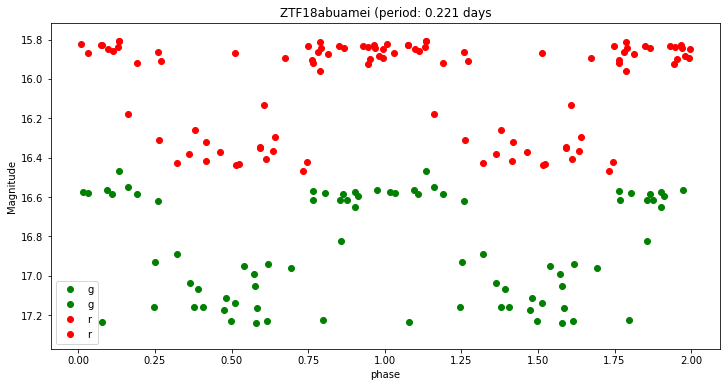

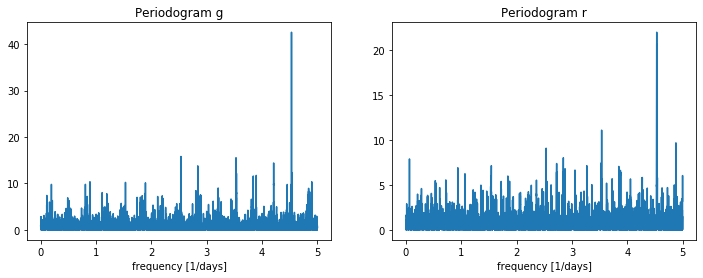

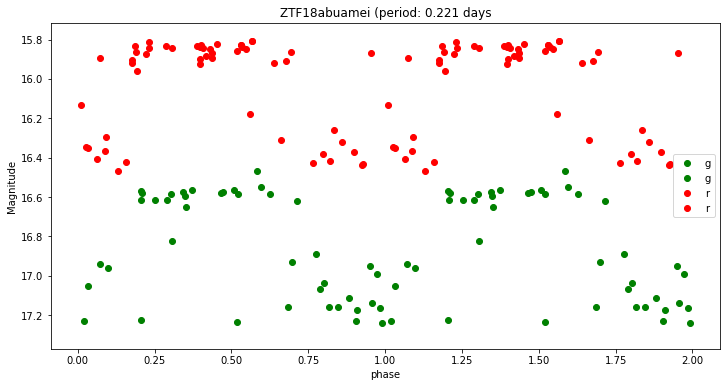

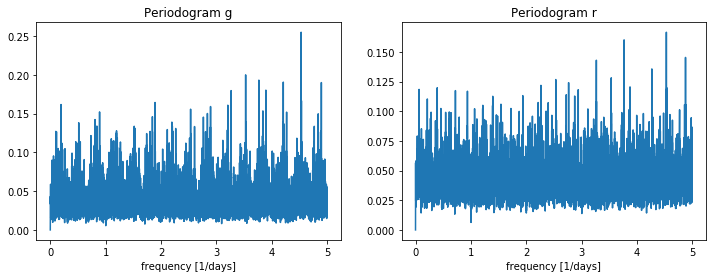

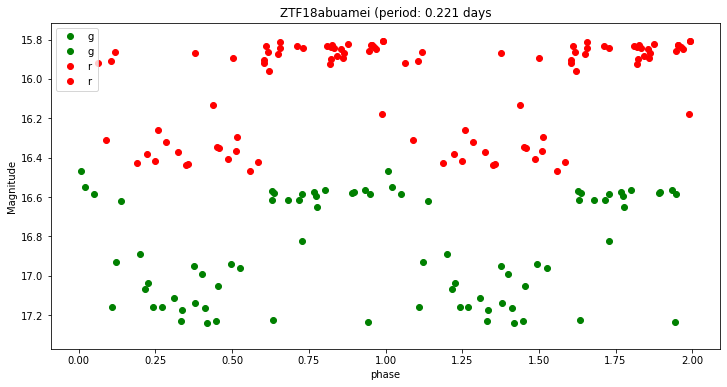

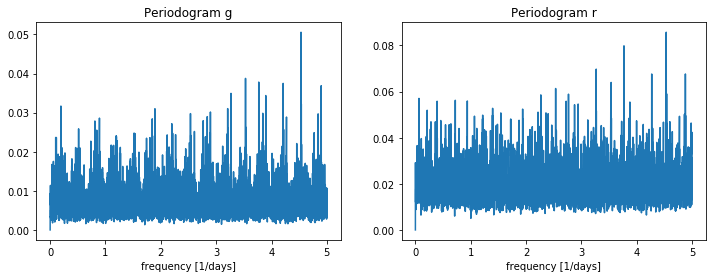

In [8]:
for method in ['PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU']:
    print(method)
    period, freq, per = doperiod(LCdet, method)
    plotLC(seloid, LCdet, LCnondet, True, period=period, freq=freq, per=per)

### Normalize the bands

In [9]:
mask_g = LCdet.fid==1
mask_r = LCdet.fid==2

# mean and standard deviation
offset_g = LCdet.loc[mask_g].magpsf_corr.mean()
width_g = LCdet.loc[mask_g].magpsf_corr.std()
offset_r = LCdet.loc[mask_r].magpsf_corr.mean()
width_r = LCdet.loc[mask_r].magpsf_corr.std()

# median and interquartile range
#offset_g = LCdet.loc[mask_g].magpsf_corr.median()
#width_g = LCdet.loc[mask_g].magpsf_corr.quantile(0.75) - LCdet.loc[mask_g].magpsf_corr.quantile(0.25)
#offset_r = LCdet.loc[mask_r].magpsf_corr.mean()
#width_r = LCdet.loc[mask_r].magpsf_corr.quantile(0.75) - LCdet.loc[mask_r].magpsf_corr.quantile(0.25)



In [10]:
LCdet["magpsf_normed"] = LCdet.apply(lambda row: (row.magpsf_corr - offset_g) / width_g if 
                                row.fid==1 else (row.magpsf_corr - offset_r) / width_r, axis=1)
LCdet["sigmapsf_normed"] = LCdet.apply(lambda row: row.sigmapsf_corr / width_g if 
                                row.fid==1 else row.sigmapsf_corr / width_r, axis=1)

In [11]:
LCdet.head()

,candid_str,dec,diffmaglim,distpsnr1,fid,field,has_stamps,isdiffpos,magap,magap_corr,...,sgscore1,sigmadec,sigmagap,sigmagap_corr,sigmagnr,sigmapsf,sigmapsf_corr,sigmara,magpsf_normed,sigmapsf_normed
candid,,,,,,,,,,,,,,,,,,,,,
615460810415015021,615460810415015021,-12.427115,20.673506,0.270039,1,351,None,1,19.272600,16.631236,...,0.995417,0.09,0.1142,0.020817,0.020,0.163973,0.024288,0.09,-0.893273,0.089699
618447010415010018,618447010415010018,-12.427132,20.680912,0.157514,1,351,None,-1,18.165701,17.067885,...,0.995417,0.09,0.0367,0.030369,0.020,0.091668,0.042936,0.09,0.765314,0.158566
621443760415015014,621443760415015014,-12.427149,20.667351,0.231355,1,351,None,1,18.851700,16.587012,...,0.995417,0.09,0.0792,0.020089,0.020,0.132692,0.025346,0.09,-1.080024,0.093606
621484910415010006,621484910415010006,-12.427163,20.407394,0.013505,2,351,None,-1,18.346500,16.182732,...,0.995417,0.09,0.0668,0.021355,0.017,0.074991,0.021652,0.09,0.590917,0.088630
624443720415010016,624443720415010016,-12.427180,20.750931,0.121711,1,351,None,-1,18.473900,16.974410,...,0.995417,0.09,0.0533,0.028385,0.020,0.065413,0.031125,0.09,0.495775,0.114947


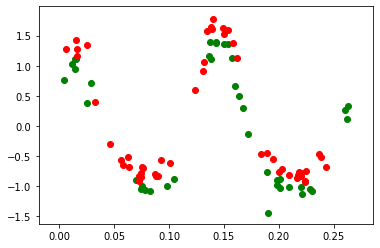

In [17]:
myperiod = 0.26530758 # this is the correct period for ZTF18abuamei
fig, ax = plt.subplots()
ax.scatter(np.mod(LCdet.loc[mask_g].mjd, myperiod), LCdet.loc[mask_g].magpsf_normed, c='g')
ax.scatter(np.mod(LCdet.loc[mask_r].mjd, myperiod), LCdet.loc[mask_r].magpsf_normed, c='r')

### Now we will fool the previous code and see what happens when we use all the points as if one band

In [18]:
LCnorm = LCdet[["mjd", "magpsf_normed", "sigmapsf_normed"]].copy()

In [19]:
LCnorm.rename({"magpsf_normed": "magpsf_corr", "sigmapsf_normed": "sigmapsf_corr"}, inplace=True, axis=1)

In [20]:
LCnorm["fid"] = 1

### And try again

PDM1
1 [0.2653097]
LKSL
1 [0.26530758]
MHAOV
1 [0.22061515]
QMICS
1 [0.22060885]
QMIEU
1 [0.2206103]


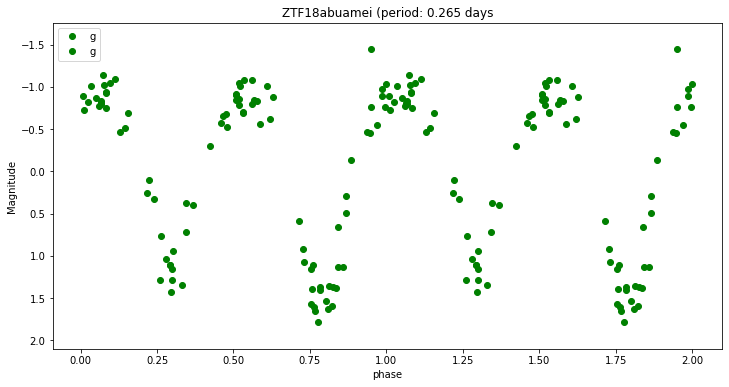

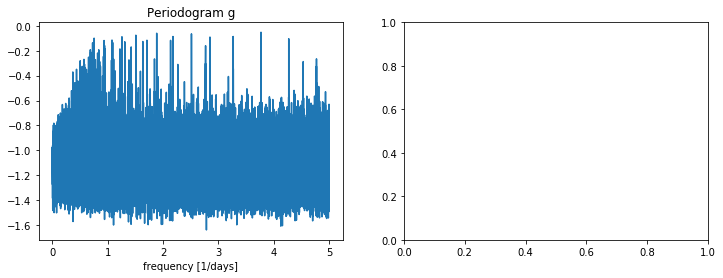

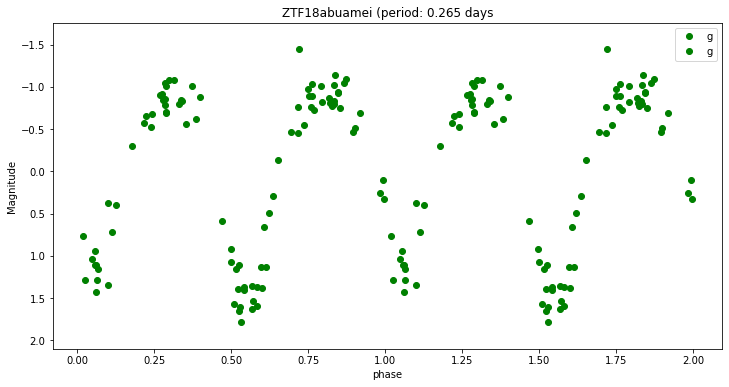

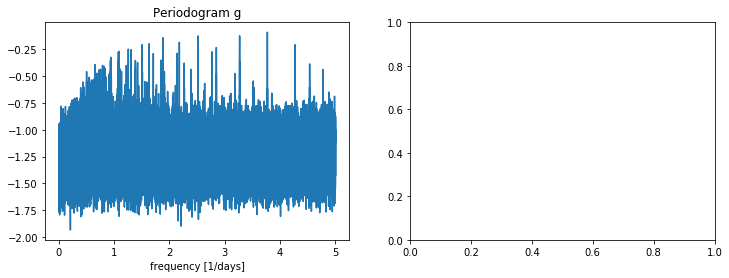

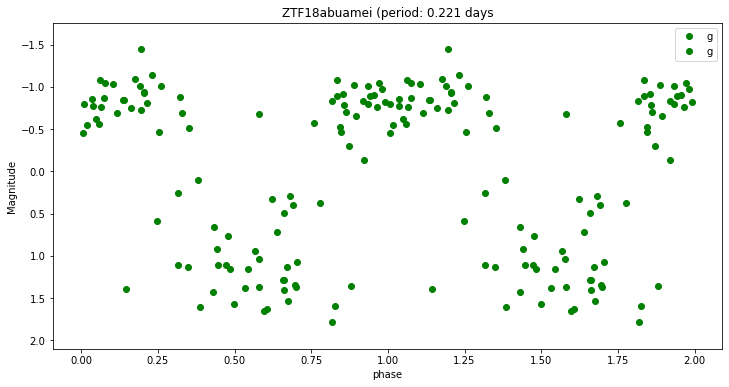

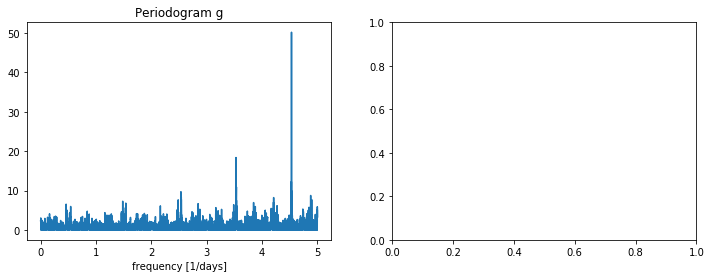

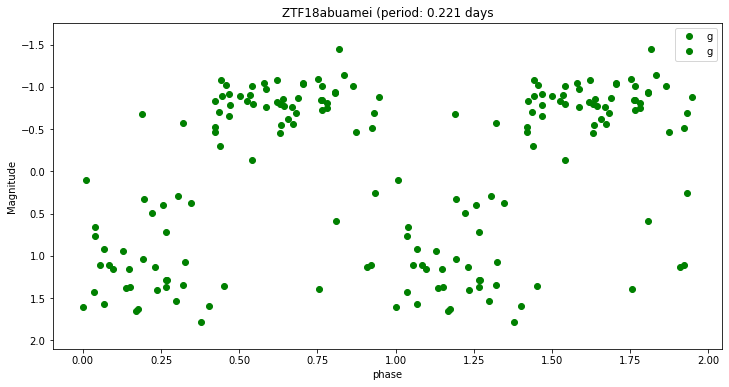

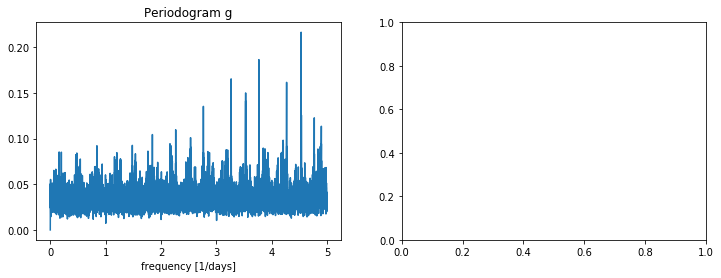

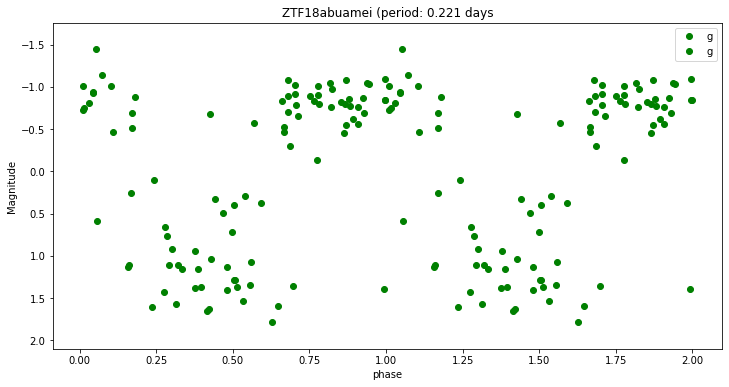

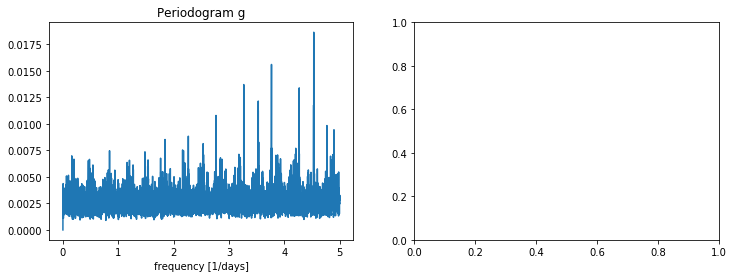

In [21]:
for method in ['PDM1', 'LKSL', 'MHAOV', 'QMICS', 'QMIEU']:
    print(method)
    period, freq, per = doperiod(LCnorm, method)
    plotLC(seloid, LCnorm, LCnondet, True, period=period, freq=freq, per=per)